In [1]:
import _init_paths
import os, sys, cv2, pickle
import os.path as osp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy.random as npr
import pandas as pd

from Config import Config
from datasets.Pascal import Pascal
from datasets.ROIGenerator import ROIGenerator
from nets.VGG16_SSDH import VGG16_SSDH
from nets.VGG16_FT import VGG16_FT

In [2]:
# setup & load configs
_C = Config(config_pn="../config/config.ini")
cfg = _C.cfg

In [3]:
ds_name = "voc_2007"
#model_pn = "../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.944.ckpt" # try 1
#model_pn = "../outputs_G1/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.977.ckpt" # try 2
#model_pn = "../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.937.ckpt" # try 3
model_pn = "../../0-bak/20180804_voc_2007_SSDH.WL2/outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.907.ckpt" # try 4
#model_pn = "../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.907.ckpt" # fc_emb, try 2
#model_pn = "../../0-bak/20180805_voc_2007_FT.WL5/outputs_G1/voc_2007/train_VGG16/VGG16_FT_iter_3132_acc_0.966.ckpt" # try 5
#model_pn = "../outputs/voc_2007/train_VGG16/VGG16_FT_iter_9396_acc_0.981.ckpt" # try 4

In [4]:
dataset_DIR = osp.join(cfg.MAIN_DIR_ROOT, "data", ds_name)
dataset = Pascal(name=ds_name, path_dir=dataset_DIR, cfg=cfg)
dataset.load_sets()
print ('[INFO] dataset.name: {}'.format(dataset.name))
print ('[INFO] dataset.num_cls: {}'.format(dataset.num_cls))
print ('[INFO] dataset.train: {}'.format(dataset.sets["train"]["num_items"]))
print ('[INFO] dataset.trainval: {}'.format(dataset.sets["trainval"]["num_items"]))
print ('[INFO] dataset.test: {}'.format(dataset.sets["test"]["num_items"]))
print ('[INFO] dataset.val: {}'.format(dataset.sets["val"]["num_items"]))

[INFO] dataset.name: voc_2007
[INFO] dataset.num_cls: 21
[INFO] dataset.train: 2501
[INFO] dataset.trainval: 5011
[INFO] dataset.test: 4952
[INFO] dataset.val: 2510


In [5]:
train_images, pos_weights = dataset.load_gt_rois(gt_set="trainval")
val_images, _ = dataset.load_gt_rois(gt_set="test")
print ('[INFO] train_images.num: {}'.format(len(train_images)))
print ('[INFO] val_images.num: {}'.format(len(val_images)))

[INFO] loading gt rois for voc_2007...
[INFO] images with gt loaded from /home/rfm/eclipse/python/region-dh/cache/voc_2007_gt_trainval_images.pkl
[INFO] loading gt rois for voc_2007...
[INFO] images with gt loaded from /home/rfm/eclipse/python/region-dh/cache/voc_2007_gt_test_images.pkl
[INFO] train_images.num: 10022
[INFO] val_images.num: 4952


In [6]:
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth=True
# init session
sess = tf.Session(config=tfconfig)

In [7]:
cfg.TEST_BATCH_CFC_NUM_IMG = 1
num_bits = 48
net = VGG16_SSDH(cfg, num_bits, multilabel=True)
#net = VGG16_FT(cfg, multilabel=True)
#net.create_architecture('TEST', dataset.num_cls, tag='default')
layers = net.create_architecture('TRAIN', dataset.num_cls, tag='default')

pool5.shape:  (32, ?, ?, 512)
fc7.shape:  (32, 1, 1, 4096)
scores.shape:  (32, 20, 2)
probs.shape:  (32, 20, 2)
preds.shape:  (32, 20, 1)
cls_score.shape:  (32, 20, 2)
labels.shape:  (32, 20)
pos_weight.shape:  (32, 1)
labels.shape:  (32, 20)
cls_pred.shape:  (32, 20, 1)


In [8]:
layers

{'loss_E1': <tf.Tensor 'LOSS_default/add_19:0' shape=() dtype=float32>,
 'loss_E2': <tf.Tensor 'LOSS_default/mul_1:0' shape=() dtype=float32>,
 'loss_E3': <tf.Tensor 'LOSS_default/mul_2:0' shape=() dtype=float32>,
 'total_loss': <tf.Tensor 'LOSS_default/total_loss:0' shape=() dtype=float32>,
 'fc_emb': <tf.Tensor 'vgg_16_2/fc_emb/Sigmoid:0' shape=(32, 1, 1, 48) dtype=float32>,
 'cls_score': <tf.Tensor 'vgg_16_2/scores:0' shape=(32, 20, 2) dtype=float32>,
 'cls_prob': <tf.Tensor 'vgg_16_2/probs:0' shape=(32, 20, 2) dtype=float32>,
 'cls_pred': <tf.Tensor 'vgg_16_2/preds:0' shape=(32, 20, 1) dtype=int64>}

In [10]:
loss = layers['total_loss']

In [11]:
lr = tf.Variable(0.001, trainable=False)
opt1 = tf.train.MomentumOptimizer(lr*0.001, 0.9)
opt2 = tf.train.MomentumOptimizer(lr, 0.9)

In [9]:
tf.trainable_variables()

[<tf.Variable 'vgg_16/fc6/weights:0' shape=(7, 7, 512, 4096) dtype=float32_ref>,
 <tf.Variable 'vgg_16/fc6/biases:0' shape=(4096,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/fc7/weights:0' shape=(1, 1, 4096, 4096) dtype=float32_ref>,
 <tf.Variable 'vgg_16/fc7/biases:0' shape=(4096,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/fc_emb/weights:0' shape=(1, 1, 4096, 48) dtype=float32_ref>,
 <tf.Variable 'vgg_16/fc_emb/biases:0' shape=(48,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/cls_score0/weights:0' shape=(48, 2) dtype=float32_ref>,
 <tf.Variable 'vgg_16/cls_score0/biases:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/cls_score1/weights:0' shape=(48, 2) dtype=float32_ref>,
 <tf.Variable 'vgg_16/cls_score1/biases:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/cls_score2/weights:0' shape=(48, 2) dtype=float32_ref>,
 <tf.Variable 'vgg_16/cls_score2/biases:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/cls_score3/weights:0' shape=(48, 2) dtype=float32_ref>,
 <tf.Vari

In [13]:
var_list = [v.name for v in tf.trainable_variables()]

In [14]:
var_list

['vgg_16/fc6/weights:0',
 'vgg_16/fc6/biases:0',
 'vgg_16/fc7/weights:0',
 'vgg_16/fc7/biases:0',
 'vgg_16/fc_emb/weights:0',
 'vgg_16/fc_emb/biases:0',
 'vgg_16/cls_score/weights:0',
 'vgg_16/cls_score/biases:0']

In [17]:
layers_1 = ['vgg_16/fc6/weights:0', 'vgg_16/fc7/weights:0']
layers_2 = ['vgg_16/fc_emb/weights:0', 'vgg_16/cls_scores/weights:0']

In [18]:
grads = tf.gradients(loss, layers_1+layers_2)
optimizer.compute_gradients(loss)

In [20]:
grads1 = grads[:len(layers_1)]
grads2 = grads[len(layers_1):]

In [9]:
print(('Loading model check point from {:s}').format(model_pn))
saver = tf.train.Saver()
saver.restore(sess, model_pn)
print('Loaded.')

Loading model check point from ../outputs/voc_2007/train_VGG16/VGG16_FT_iter_9396_acc_0.981.ckpt
INFO:tensorflow:Restoring parameters from ../outputs/voc_2007/train_VGG16/VGG16_FT_iter_9396_acc_0.981.ckpt
Loaded.


In [10]:
def im_classify(sess, net, image, data_gen):
    random_scale_inds = npr.randint(0, high=len(cfg.TEST_DEFAULT_SCALES),size=1)
    
    im_blob, im_scales = data_gen.built_image_blob([image], random_scale_inds)
    #label_blob = data_gen.built_label_blob([image])
    
    cls_score, cls_prob, cls_pred = net.test_image(sess, im_blob)
    
    return cls_score, cls_prob, cls_pred

In [11]:
val_gen = ROIGenerator(val_images, dataset, None, cfg)

image.lp:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
image.labels:  ['bird']
gt_classes:  [3]


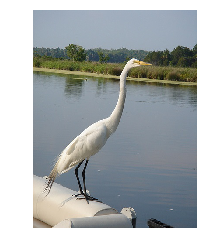

In [13]:
# visualize image
np.random.shuffle(val_images)
image = val_images[0]
im_RAW = cv2.imread(image.pathname)   
im_RAW = cv2.cvtColor(im_RAW, cv2.COLOR_BGR2RGB)
lp = image.rois["gt"]["labels"]
labels = lp_to_names(lp, dataset)
gt_classes = image.rois["gt"]["gt_classes"]
print("image.lp: ", lp)
print("image.labels: ", labels)
print("gt_classes: ", gt_classes)
plt.imshow(im_RAW)
_ = plt.axis("off")

In [14]:
cls_score, cls_prob, cls_pred = im_classify(sess, net, image, val_gen)

In [15]:
labels = lp_to_names(cls_pred[0],dataset)
keep = np.where(cls_pred[0] == 1)[-1]
probs = cls_prob[0][keep]
print("labels: ", labels)
print("probs: ", probs)

labels:  ['bird', 'boat']
probs:  [0.99994063 0.6344867 ]


#### Evaluate val data

In [16]:
cls_probs = []
cls_preds = []
all_lp = []
all_labels = []
filenames = []
pathnames = []

for i, image in enumerate(val_images):
    if i%500 == 0:
        print("processed {}/{}".format(i, len(val_images)))
    
    #cls_score, cls_prob, cls_pred = im_classify(sess, net, image, val_gen)    
    #"""
    try:
        cls_score, cls_prob, cls_pred = im_classify(sess, net, image, val_gen)
    except:
        print("[ALERT] exception on ", image.filename)
        continue
    #"""
    filenames.append(image.filename)
    pathnames.append(image.pathname)
    lp = image.rois["gt"]["labels"]
    all_lp.append(lp)
    labels = lp_to_names(lp, dataset)
    all_labels.append(labels)    
    cls_probs.append(cls_prob[0])
    cls_preds.append(cls_pred[0])

processed 0/4952
[ALERT] exception on  006491.jpg
[ALERT] exception on  004900.jpg
processed 500/4952
processed 1000/4952
processed 1500/4952
[ALERT] exception on  002018.jpg
processed 2000/4952
processed 2500/4952
processed 3000/4952
[ALERT] exception on  001744.jpg
processed 3500/4952
[ALERT] exception on  005137.jpg
processed 4000/4952
processed 4500/4952
[ALERT] exception on  000533.jpg


In [17]:
data = {"filename": filenames, "pathname": pathnames, 
       "labels": all_labels, "lp": all_lp, "cls_pred": cls_preds, "cls_prob": cls_probs}
df_val_images = pd.DataFrame(data)

In [18]:
df_val_images.head()

,filename,pathname,labels,lp,cls_pred,cls_prob
0,007047.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,[bird],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.4343753e-05, 0.011981717, 0.99994063, 0.634..."
1,007986.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,[person],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.00014627862, 0.002412237, 0.00016671969, 4...."
2,006600.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,[train],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.004191517, 0.0010109156, 1.7095743e-06, 0.0..."
3,007596.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,"[dog, sheep]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,007929.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,"[person, sofa]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[7.023129e-05, 0.0004221355, 0.00015711923, 0...."


In [19]:
with open("../data/voc_2007/20180806_df_val_images_FT.wl4.pkl",'wb') as fp:
    pickle.dump(df_val_images, fp)

In [20]:
cls_to_id = dataset.cls_to_id
id_to_cls = {v:k for (k,v) in cls_to_id.items()}

In [21]:
targets = np.array(list(df_val_images["lp"]))
targets = np.reshape(targets, [targets.shape[0], -1])
print(targets.shape)

(4946, 20)


In [22]:
preds = np.array(list(df_val_images["cls_pred"]))
preds = np.reshape(preds, [preds.shape[0], -1])
print(preds.shape)

(4946, 20)


In [23]:
from sklearn.metrics import precision_score, recall_score

In [24]:
evals = {}
mAP = 0

for id_cls in range(targets.shape[1]):
    prec = precision_score(targets[:, id_cls], preds[:, id_cls], average='weighted')
    rec = recall_score(targets[:, id_cls], preds[:, id_cls], average='weighted')
    
    if prec <= 0 or rec <= 0:
        f1_score = 0
    else:
        f1_score = 2*prec*prec/(prec+rec)
        
    evals[id_to_cls[id_cls+1]] = [f1_score]
    mAP += f1_score
    
mAP = mAP/targets.shape[1]
evals["mAP"] = [mAP]
    
df_evals= pd.DataFrame(evals)

In [25]:
# wl.4
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.993564,0.984142,0.988449,0.988804,0.958577,0.982673,0.93892,0.982594,0.935564,0.988532,...,0.971432,0.982737,0.98448,0.876345,0.959228,0.991144,0.951839,0.987339,0.971525,0.969693


In [26]:
# wl.5
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.991267,0.984715,0.984858,0.988292,0.954906,0.980675,0.94127,0.981221,0.929575,0.985593,...,0.968401,0.98014,0.98088,0.873216,0.951656,0.989428,0.952763,0.986989,0.970519,0.967554


In [21]:
# ssdh, wl.2
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.899378,0.87809,0.859872,0.913249,0.882796,0.90989,0.650714,0.840034,0.745596,0.936958,...,0.794905,0.864522,0.886571,0.680138,0.876681,0.952134,0.83044,0.873866,0.875742,0.851554


In [21]:
# wl.4
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.993052,0.983983,0.986421,0.989828,0.958817,0.983571,0.938369,0.983758,0.933821,0.988076,...,0.973615,0.982413,0.983188,0.871855,0.959349,0.990862,0.951772,0.98795,0.970583,0.969414


In [20]:
# wl.3
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.990101,0.985251,0.984076,0.98702,0.94918,0.983165,0.946772,0.98219,0.917613,0.977977,...,0.967671,0.981779,0.983974,0.90135,0.94048,0.988135,0.946476,0.989187,0.96784,0.967092


In [20]:
# wl.2
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.993052,0.984142,0.986477,0.990037,0.958702,0.983571,0.939336,0.983525,0.933763,0.987727,...,0.974554,0.982266,0.983205,0.872043,0.957893,0.990786,0.95163,0.98795,0.970391,0.969393


In [64]:
# wl.1
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.989883,0.9851,0.983481,0.986652,0.947858,0.982931,0.945889,0.981869,0.914532,0.977797,...,0.967398,0.982287,0.983795,0.901293,0.942819,0.987618,0.945761,0.988716,0.966327,0.966652


In [22]:
#evals

In [27]:
#df_evals.to_csv("../data/voc_2007/20180806_df_evals_FT.wl4.csv")